## Section C: Bayesian Optimisation

Bayesian Optimisation is an iterative, active learning, global optimisation algorithm. The core workflow for a BO algorithm is as follows. 

1. Construct surrogate model based on avaiable training data
2. Obtain 'best' point in input space for evaluation via acquisition function 
3. Evaluation of 'best' point and append result to trainnig data
4. Repetition of steps 1 to 3 until termination criteria met (suitable minima found or resources consumed.)

BO is a method to obtain an optimised set of inputs from a search space with minimal resources. BO is great for cases wheen evaluations are expensive (for example, if an labroratory experiment is required to evluate outcomes for an optimisation campaign.)

We have observed the first step in great detail in section B. Gaussian processes remain a popular choice for a surrogate model as it produces both the prediceted outcome (the mean) and an associated uncertainty which can be exploited in step 2.

In this section, we will explore acquisition functions, the concept of exploration vs explotation, the iterative nature of the BO workflow and effects of training data sampling to arrive at a fully functioning optimiser algorithm!


### Importing Relevant Packages
(Feel free to import any packages you feel like needing to fully explore the content!)


In [ ]:
# if using google collab, run the following pip installs!
!pip install sobol_seq
!pip install plotly
!pip install gpytorch
!pip install rdkit

We will be using the GP_model_meanzero class section B. Instead of defining it in this notebook. I have placed the class in a subdirectory called gaussian_process_class in a .py file called GP.py. We can access the class by importing the .py file as a package. 

```python
from gaussian_process_class import GP

#to access the class
GP.GP_model_meanzero
```

If using Collab, please run the GP class below instead!

```python
class GP_model_meanzero:

    def __init__(self, X, Y, kernel, hyperparams_multistart_loops):
        self.X, self.Y, self.kernel = X, Y, kernel
        self.number_of_point, self.nx_dimensions, self.ny_dimensions = X.shape[0], X.shape[1], Y.shape[1]
        self.multistart_loops            = hyperparams_multistart_loops

        #Normalisation
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

        #Determine Kernel Hyperparameters 
        self.hyperparam_optimized , self.inverse_covariance_matrix_opt   = self.determine_hyperparameters()     
        
    def Cov_mat(self, kernel, X_norm, W, sf2):
        if kernel == 'SquaredExponential':
            xixj_euclidean_distance = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*xixj_euclidean_distance)
            return (cov_matrix)
        else:
            print('ERROR no kernel with name ', kernel)


    def negative_loglikelihood(self, hyper, X, Y):
        # internal parameters
        n_point, nx_dim = self.number_of_point, self.nx_dimensions
        kernel          = self.kernel
         
        W               = np.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = np.exp(2*hyper[nx_dim])    # variance of the signal 
        sn2             = np.exp(2*hyper[nx_dim+1])  # variance of noise

        # obtaining negative logliklihood via Cholesky decomposition 
        K       = self.Cov_mat(kernel, X, W, sf2)  
        K       = K + (sn2 + 1e-8)*np.eye(n_point) 
        K       = (K + K.T)*0.5                   
        L       = np.linalg.cholesky(K)            
        logdetK = 2 * np.sum(np.log(np.diag(L)))   
        invLY   = np.linalg.solve(L,Y)             
        alpha   = np.linalg.solve(L.T,invLY)       
        NLL     = np.dot(Y.T,alpha) + logdetK     
        return (NLL)

    
    def determine_hyperparameters(self): 
        # setting up bounds for the log likelyhood minimsation
        lower_bound = np.array([-4.]*(self.nx_dimensions+1) + [-8.])  # lengthscales + signal variance, noise variance
        upper_bound = np.array([4.]*(self.nx_dimensions+1) + [ -2.]) 
        bounds      = np.hstack((lower_bound.reshape(self.nx_dimensions+2,1), upper_bound.reshape(self.nx_dimensions+2,1)))

        #gives number of input set of random starting guesses for each hyperparameter
        multi_startvec         = sobol_seq.i4_sobol_generate(self.nx_dimensions + 2, self.multistart_loops)
        
        #variables for storing information during loop
        temp_min_hyperparams   = [0.]*self.multistart_loops
        temp_loglikelihood     = np.zeros((self.multistart_loops))
        hyperparam_optimized   = np.zeros((self.nx_dimensions+2, self.ny_dimensions)) #for best solutions
        inverse_covariance_matrix_opt = []
        
        #minimisation of hyperparameters
        for i in range(self.ny_dimensions):
            for j in range(self.multistart_loops ):
                #initilising hyperparam guess
                hyperparams_initialisation   = lower_bound + (upper_bound-lower_bound)*multi_startvec[j,:] # mapping sobol unit cube to boudns
               
                result = minimize(self.negative_loglikelihood,
                               hyperparams_initialisation,
                               args=(self.X_norm, self.Y_norm[:,i]),
                               method='SLSQP',
                               options={'disp':False,'maxiter':10000},
                               bounds=bounds,
                               tol=1e-12)
                
                temp_min_hyperparams[j] = result.x
                temp_loglikelihood[j]   = result.fun  

            # choosing best solution from temporary lists
            minimumloglikelihood_index    = np.argmin(temp_loglikelihood)
            hyperparam_optimized[:,i]     = temp_min_hyperparams[minimumloglikelihood_index  ]
    
            # exponential to recover value from log space
            lengthscale_opt         = np.exp(2.*hyperparam_optimized[:self.nx_dimensions,i])
            signalvarience_opt      = np.exp(2.*hyperparam_optimized[self.nx_dimensions,i])
            noise_opt               = np.exp(2.*hyperparam_optimized[self.nx_dimensions+1,i]) + 1e-8
    
            #obtain convarience matrix from optimised kernel hyper parameters
            covarience_matrix_opt              = self.Cov_mat(self.kernel, self.X_norm, lengthscale_opt,signalvarience_opt) + noise_opt*np.eye(self.number_of_point)
            self.covarience_matrix_opt         = covarience_matrix_opt
            inverse_covariance_matrix_opt     += [np.linalg.solve(covarience_matrix_opt, np.eye(self.number_of_point))]
            
        return (hyperparam_optimized , inverse_covariance_matrix_opt)

    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        # internal parameters
        nx_dim = self.nx_dimensions

        #covariance of sample
        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)
        return (cov_matrix )         


    def GP_inference_np(self, x):
        nx_dim                   = self.nx_dimensions
        kernel, ny_dim           = self.kernel, self.ny_dimensions
        hypopt, Cov_mat          = self.hyperparam_optimized, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.inverse_covariance_matrix_opt
        Xsample, Ysample         = self.X_norm, self.Y_norm

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        
        # ny_dim -> number of outputs
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])

            # calculation of covaraince for each output
            # although noise hyperparameter determiend, it is ignored here for better visualisation
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k)) 

        # un-normalisation (obtianing actual mean and variance) 
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        
        return (mean_sample, var_sample)
```

In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.integrate import quad
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import math
import time
import sobol_seq

from gaussian_process_class import GP

### Acquisition Functions and Bayesian Optimisation

The role of the acquisition function is to obtain a set of un-evaluated set of input values with the highest utility (that is the 'best' point which the user should evaluate) towards obtianing the optimum. In the end of section B, we were asked to ponder about how the output of the GP regressor (the predicted mean and the associated standard deviation) can help us in this endeavour. 

One method of choosing which points to evaluate is to choose points which allows us to explore the input space -> points with the highest uncertainity or to exploit the input space -> points with the highest predicted mean (when maximising). 

#### Section C1: Exploration vs Exploitation

Below is a fully functioning BO class with acquisition functions to either explore or exploit.

``` python
class BO_1D: 
    def __init__(self, X, kernel, X_searchspace,  iterations, acquisition_function, objective_func, print_graph, acquisition_hyperparam):       
        
        self.X                   = X
        Fx_training              = np.array([objective_func(x) for x in self.X])
        self.Y                   = Fx_training.reshape(Fx_training.shape[0],1)
        
        fx_searchspace           = np.array([objective_func(x) for x in X_searchspace])
        Ysearchspace_mean        = np.zeros(number_points_searchspace)
        Ysearchspace_std         = np.zeros(number_points_searchspace)
        
        self.minY      = []
        self.exploredY = []
        
        for i in range(iterations):
            GP_m = GP.GP_model_meanzero(self.X, self.Y, kernel, hyperparams_multistart_loops = 3)
            
            for number in range(len(X_searchspace)):
                m_ii, std_ii   = GP_m.GP_inference_np(X_searchspace[number])
                Ysearchspace_mean[number] = m_ii.item()
                Ysearchspace_std[number]  = std_ii.item()
            
            if acquisition_function == 'greedy':
                X_acquisitionfunc   = self.greedy_fullexplotative(X_searchspace,Ysearchspace_mean, Ysearchspace_std )     
                
            elif acquisition_function == 'explore':
                X_acquisitionfunc     = self.fullexplorative(X_searchspace,Ysearchspace_mean, Ysearchspace_std ) 
                
            else: 
                print('No acquisition function called ', acquisition_function)
                break
            
            self.X = np.append(self.X, [[X_acquisitionfunc]],0)
            self.Y = np.append(self.Y, [[objective_func(X_acquisitionfunc)]],0)
            self.minY      += [min(self.Y)]
            self.exploredY += [objective_func(X_acquisitionfunc)]

            if print_graph == True: 
                plt.figure(figsize = (8,3), dpi = 100)
                plt.plot(self.X[:-1], self.Y[:-1], 'kx', mew=2, label = 'Training Data')
                plt.plot(X_searchspace, fx_searchspace , 'black', linewidth=1, label = 'Objective Function')
                plt.plot(X_searchspace, Ysearchspace_mean, 'C0', lw=2, label = 'GP Predicted Mean')
                plt.gca().fill_between(X_searchspace, 
                                       Ysearchspace_mean - 3*np.sqrt(Ysearchspace_std), 
                                       Ysearchspace_mean + 3*np.sqrt(Ysearchspace_std), 
                                       color='C0', alpha=0.2)
                plt.axvline(x = X_acquisitionfunc , color = 'b', label = 'Input for Evaluation')
                plt.legend(fontsize = 8)
                plt.show()
            else: 
                pass
        plt.figure(figsize = (8,4), dpi = 100)
        plt.title('Minimum of Training Data set over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.minY)
        plt.show()
        plt.figure(figsize = (8,4), dpi = 100)
        plt.title('Evaluation Output over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.exploredY)
        plt.show()
    
    def greedy_fullexplotative(self, X_searchspace, Ysearchspace_mean, Ysearchspace_std):
        return (X_searchspace[np.argmin(Ysearchspace_mean)])

    def fullexplorative(self, X_searchspace, Ysearchspace_mean, Ysearchspace_std):
        return (X_searchspace[np.argmax(Ysearchspace_std)])   

```

#### Excersise C1_1: 
##### Concepts: BO, exploration vs explotation, acquisition functions

In this first activity, observe the BO class above and map out which sections of the code is responsible for the following workflow? 

1. Construct surrogate model based on avaiable training data
2. Obtain 'best' point in input space for evaluation via acquisition function
3. Evaluation of 'best' point and append result to trainnig data
4. Repetition of steps 1 to 3 until termination criteria met (number of iterations completed, suitable minima found or resources consumed.)

Excecute the code. 

#### Excersise C1_2: 
##### Concepts: BO, exploration vs explotation, acquisition functions

We are now going to run our first BO algorithm using the fully exploration algorithm! Let's perform minimisation on the objection function $f(x) = sin({x^{sinx})}$ with an interested input space between $x = 3$ and $x = 8$. A plot of the objective function is as follows. We observe 2 minima! The global minimum is (7.1874, -1).

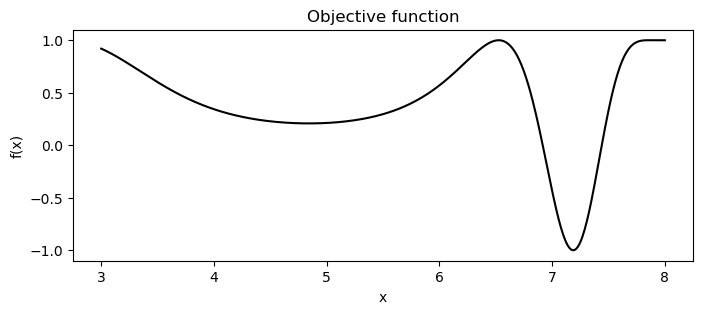

Unlike in section B with the GP class, we no longer need to define the output space as it is now built into the BO class. We just need to prepare the input training data and the interested input space.

An example is as follows:

```python
def obj_func(x):
	return np.sin(x**np.sin(x))

# --- define training data --- 
X_training = np.array([3.5,4,5])
ndata  = X_training.shape[0]
X_training = X_training.reshape(ndata,1)

# --- define search space --- 
number_points_searchspace      = 500
X_searchspace     = np.linspace(3, 8.0, num=number_points_searchspace)
```
We can perform BO with this line of code. Because the acquisition function does not include any hyperparameters, we can input a blank list. 

```python
BO_m = BO(X = X_training,  
       kernel = 'SquaredExponential', 
       X_searchspace = X_searchspace, 
       iterations = 25, 
       acquisition_function = 'explore', 
       objective_func = obj_func, 
       print_graph = True, 
       acquisition_hyperparam=[])
```

Run the BO algorithm with the specified training data and search space above over 25 iterations! Since we have enabled the graphs to be printed, we will see the outcome of the acquisition function over each iteration. This is the blue verticle line. Since we have selected the explorative acquisition function, notice that the blue line is located where there is highest uncertainty (for graphs with multiple same and highest uncertainty, the algorithm chooses the smallest input). 

You would also see on the last two graphs how the bayesian optimisation perfomed over time. The first graph shows the minimum found of within the trianing data set (this includes those which are appended) and the second shows the evaluated output over iterations. We see that the algorithm has found an input with a lower output when compared to the original training data set just by exploration! (See top graph) However, we do not see observed minimisation. (see bottom graph) 

#### Excersise C1_3: 
##### Concepts: BO, exploration vs explotation, acquisition functions

Run the BO algorithm again but with the greedy acquisition function! We would see the points to be evaluated falls on the lowest predicted mean. Although we see that it is minimizing (see the last graph), it is trapped in a local minima! 

How can we balance both exploitation and exploration? 

#### Excersise C1_4: 
##### Concepts: Lower Confidence Bound, acquisition function

One way to balance both exploration and exploitation is through using both the mean and uncertainty term. The lower confidence bound is an acquisition function that describes the input space with highest utility as the minima point of the lower confidence. (this is the boundary of the lower part of the light blue shaded region - colored in teal in the graph below)

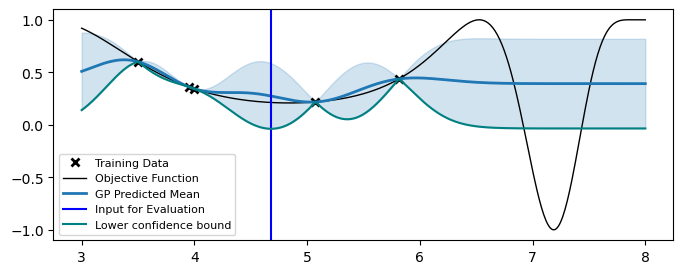

Mathematically, the LCB can be described as. 

$$
LCB(x) = \mu(x) - \kappa\sigma(x)
$$

Where $\kappa$ is a hyper parameter scaling the standard deviation. 

Modify the BO_1D class by adding a lower confidence bound acquisition function. We have plotted the shaded blue shaded region as 3 standard deviations, therefore let $\kappa = 3$. You can use the `acquisition_hyperparam` variable to input the hyperparameters as a list `= [3]` and then unpack the list when required. 

Once modified, run the BO algorithm with the same training points with the iterations set to 50. Does the BO do both explore and minimize?

#### Excersise C1_5: 
##### Concepts: Lower Confidence Bound, acquisition function

If performed correctly, you would see that it was still trapped in the local minima! Meaning, the acquisition function does not allow for enough exploration. We can modify this by increasing the contribution from the standard deviation by increasing the hyperparameter $\kappa$.

Explore how varying $\kappa$ affects the optimisation algorithm. What is the best value for $\kappa$ - how fast does it converge? Reminder that the minima of the objective function is (7.1874, -1).

#### Excersise C1_6: 
##### Concepts: Lower Confidence Bound, acquisition function

The previous objective function is simple with only 2 minima and in a small search space. You will now perform some BO with different objective functions. Remember that real-life applications of BO involve objective functions which are usualy unknown. 

Using LCB, explore how changing $\kappa$ affects the performance of the optimisation of the following objective function over the specified training points and search space of interest. 


Objective function: $f(x) = -{x^{0.1}}sin(5x) + 0.02x$

Training points: `[0,1,2,3,4]`

Search space: from $x = 0$ to $x = 10$ 

#### Excersise C1_7: 
##### Concepts: Lower Confidence Bound, acquisition function

Using LCB, explore how changing $\kappa$ affects the performance of the optimisation of the following objective function over the specified training points and search space of interest. 

Objective function: $f(x) = -x-(x-{x^2}{){^{0.9}}}$

Training points: `[0.1,0.3,0.5]`

Search space: from $x = 0$ to $x = 1$ 

Compare the result to the previous excersise. Which converged faster? Why is one harder to optimise compared to another? 

#### Excersise C1_8: 
##### Concepts: Training Data Points

The training data set was specified in all previous excersies. Here, we will see how the intial trianing data set affects the performance of our BO algorithm. 

There are a few ways how one could pick the initial traning data: random, biased, regular sampling etc. The previous training data sets were biased/skwed towards data points away from the global maximum. Using the objective function from excersise C1_6, explore how different sets of training data affect the optimisation. We will contrain the number of training point to 10.

Initally set $\kappa$ = 3. Then explore the effects of varying both $\kappa$ and the training data set.

Objective function: $f(x) = -{x^{0.1}}sin(5x) + 0.02x$

Search space: from $x = 0$ to $x = 10$ 


``` python
# random
X_training = np.random.rand(10)
# biased towards small input numbers
X_training = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5])
#regularly sampled across search space 
X_training = np.array([0,1,2,3,4,5,6,7,8,9])
```


#### Excersise C1_9: 
##### Concepts: Multidimensional BO

The penultimate task is to observe how multidimensional BO can be performed with our code. A 2D BO class is found below (the graphing function will show a 3D plot instead of 2D).

Similar to GP inputs, BO_2D class is built to recieve multidimensional matrices of shape N x M where N is the number of points and M is the number of dimensions as inputs. One can contruct these multidimensional arrays mannually, or use a recursively. In the same fashion, we must modify our interested input space and empty matrix to have the correct 2 dimensional shape. (See end of section B to see and example of how to contruct this.)

```python
class BO_2D: 
    def __init__(self, X, kernel, X_searchspace,  iterations, acquisition_function, objective_func, print_graph, acquisition_hyperparam):       
        
        self.X = X

        Fx_training              = np.array([objective_func(x) for x in self.X])
        self.Y                   = Fx_training.reshape(Fx_training.shape[0],1)
        
        fx_searchspace           = np.array([objective_func(x) for x in X_searchspace])
        Ysearchspace_mean        = np.zeros(number_points_searchspace)
        Ysearchspace_std         = np.zeros(number_points_searchspace)
        
        self.minY = []
        self.exploredY = []
        
        for i in range(iterations):
            GP_m = GP.GP_model_meanzero(self.X, self.Y, kernel, hyperparams_multistart_loops = 3)
            
            for number in range(len(X_searchspace)):
                m_ii, std_ii   = GP_m.GP_inference_np(X_searchspace[number])
                Ysearchspace_mean[number] = m_ii.item()
                Ysearchspace_std[number]  = std_ii.item()
        
            if acquisition_function == 'LCB':
                X_acquisitionfunc = self.lower_confidence_bound(X_searchspace,Ysearchspace_mean, Ysearchspace_std,acquisition_hyperparam )
            else: 
                print('No acquisition function called ', acquisition_function)
                break
            
            self.X = np.append(self.X, [X_acquisitionfunc],0)
            self.Y = np.append(self.Y, [[objective_func(X_acquisitionfunc)]],0)

            self.minY += [min(self.Y)]
            self.exploredY += [objective_func(X_acquisitionfunc)]

            if print_graph == True: 
                ax = plt.figure().add_subplot(projection='3d')
                ax.scatter(self.X[:-1,0],self.X [:-1,1] ,self.Y[:-1][0], zdir='z', color = 'black', alpha = 1, label ='Training Data Set')
                ax.scatter(self.X[-1,0],self.X [-1,1] ,self.Y[0][-1], zdir='z', color = 'darkorange', alpha = 1, label ='Evaluated Point')
                ax.scatter(X_searchspace[:,0],X_searchspace[:,1] ,np.array([objective_func(x) for x in X_searchspace]), zdir='z', color = 'lightblue', alpha = 0.01, label ='Objective Function')
                ax.view_init(elev=30, azim=45)
                plt.title(f'Training Data Points on Objective function - Iteration {i}')
                plt.show()
                ax = plt.figure().add_subplot(projection='3d')
                ax.scatter(self.X[:-1,0],self.X [:-1,1] ,self.Y[:-1][0], zdir='z', color = 'black', alpha = 1, label ='Training Data Set')
                ax.scatter(self.X[-1,0],self.X [-1,1] ,self.Y[0][-1], zdir='z', color = 'darkorange', alpha = 1, label ='Evaluated Point')
                ax.scatter(X_searchspace[:,0],X_searchspace[:,1] ,np.array([objective_func(x) for x in X_searchspace]), zdir='z', color = 'lightblue', alpha = 0.01, label ='Objective Function')
                ax.view_init(elev=90, azim=0)
                plt.title(f'Training Data Points on Objective function - Iteration {i}')
                plt.show()
            else: 
                pass
        plt.figure(figsize = (8,4), dpi = 100)
        plt.title('Minimum of Training Data set over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.minY)
        plt.show()
        plt.figure(figsize = (8,4), dpi = 100)
        plt.title('Evaluation Output over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.exploredY)
        plt.show()
    
    def lower_confidence_bound(self, X_searchspace, Ysearchspace_mean, Ysearchspace_std, acquisition_hyperparam = [3]):
        lower_std = Ysearchspace_mean - acquisition_hyperparam[0]*np.sqrt(Ysearchspace_std)
        return (X_searchspace[np.argmin(lower_std)])

```

Using the objective function below, perform BO with 50 iterations with the lower confidence bound acquisition function, a `kappa = 3` and an interested search space from -5 to 8 for both dimensions. You can specify your own training data set, but the number of points should not exceed 5 points. 

```python
# Objective function
def obj_func(X):
	return (np.sin(X[0])+np.sin(X[1]))

# Define training data
X_training =  ...

# Define search space
X_searchspace     =  ...

# Run BO_2D
BO_m = BO_2D(X = X_training,  
                ...,)
```

### End of Section 

Well done for completing the section!

You are now equipped with the knowledge of Bayesian Optimisation! Amazing work!